In [71]:
import pandas as pd
import seaborn as sns
from IPython.display import display

In [72]:
import numpy as np
from glob import glob
from json import loads

glob_path = "./implementation/test/history/**/*.json"

runs = []
for run_output_filepath in glob(glob_path, recursive=True):
    with open(run_output_filepath) as run_output:
        run_json = loads(run_output.read())
        runs.append(run_json)

if not runs:
    raise Exception("No runs found")
else:
    print(f"Found {len(runs)} runs")


df = pd.DataFrame(runs)
df = df.rename(columns={
    "lang": "language"
})

df = df.assign(
    # Super fragile replace but works for now
    payload=lambda df: df["payload"].map(
        lambda payload: loads(payload.replace(";", ","))),

    runtime=lambda df: df["runtime"].astype(float),
    roundTripTime=lambda df: df["roundTripTime"].astype(float),
    newcontainer=lambda df: df["newcontainer"].astype(int),

    filter=lambda df: df["payload"].map(
        lambda payload: f"{payload['filter']} x {payload.get('repeats', 1)}"),
    filename=lambda df: df["payload"].map(lambda payload: payload["key"]),
    containerState=lambda df: np.where(
        df["newcontainer"] == 1, "cold", "hot"
    ),
    language=lambda df: df["language"].map({
        "java": "Java",
        "node.js": "JavaScript",
    }),

    pixelDimensions=lambda df: df["filename"].map(
        lambda filename: tuple(map(int, filename.split("@")[0].split("x")))),
    pixelAmount=lambda df: df["pixelDimensions"].map(
        lambda dimensions: dimensions[0] * dimensions[1]),

    shortName=lambda df:
    df["filename"].map(lambda filename: filename.split("-")[1].strip()[:-4]),

    fileID=lambda df: df["shortName"] + " " + df["pixelDimensions"].astype(str),
)

Found 682 runs


In [79]:
from ipywidgets import widgets

def create_global_widgets():
    global_widgets = {}
    for (columnName, columnData) in df.items():
        try:
            if type(columnName) == str:
                global_widgets[columnName] = widgets.Dropdown(
                    options=columnData.unique(),
                    description=columnName,
                    disabled=False,
                )
        except Exception as e:
            print(columnName, ":", e)
    return global_widgets

columns_to_display = {
    "cpuType", "language", "functionName", "containerState", "filter",
    "pixelAmount", "shortName", "fileID", "filename",
}
global_widgets = create_global_widgets()
display(*(
    global_widget
    for column, global_widget
    in global_widgets.items()
    if column in columns_to_display
))

payload : unhashable type: 'dict'
key : Invalid selection: value not found
bucket : Invalid selection: value not found
message : Invalid selection: value not found


Dropdown(description='cpuType', options=('Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63', 'Intel(R) Xeon(R) …

Dropdown(description='language', options=('Java', 'JavaScript'), value='Java')

Dropdown(description='functionName', options=('imageProcessingJava', 'imageProcessingJavaScript'), value='imag…

Dropdown(description='filter', options=('flipVertical x 1', 'greyscale x 1', 'soften x 16', 'soften x 8', 'sof…

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

Dropdown(description='containerState', options=('hot', 'cold'), value='hot')

Dropdown(description='pixelAmount', options=(2500, 65536, 326200, 2304000, 8294400, 19961856), value=2500)

Dropdown(description='shortName', options=('osu', 'husky', 'vietfood', 'deathstar', 'mountains', 'lanterns'), …

Dropdown(description='fileID', options=('osu (50, 50)', 'husky (256, 256)', 'vietfood (700, 466)', 'deathstar …

Dropdown(description='shortName', options=('osu', 'husky', 'vietfood', 'deathstar', 'mountains', 'lanterns'), …

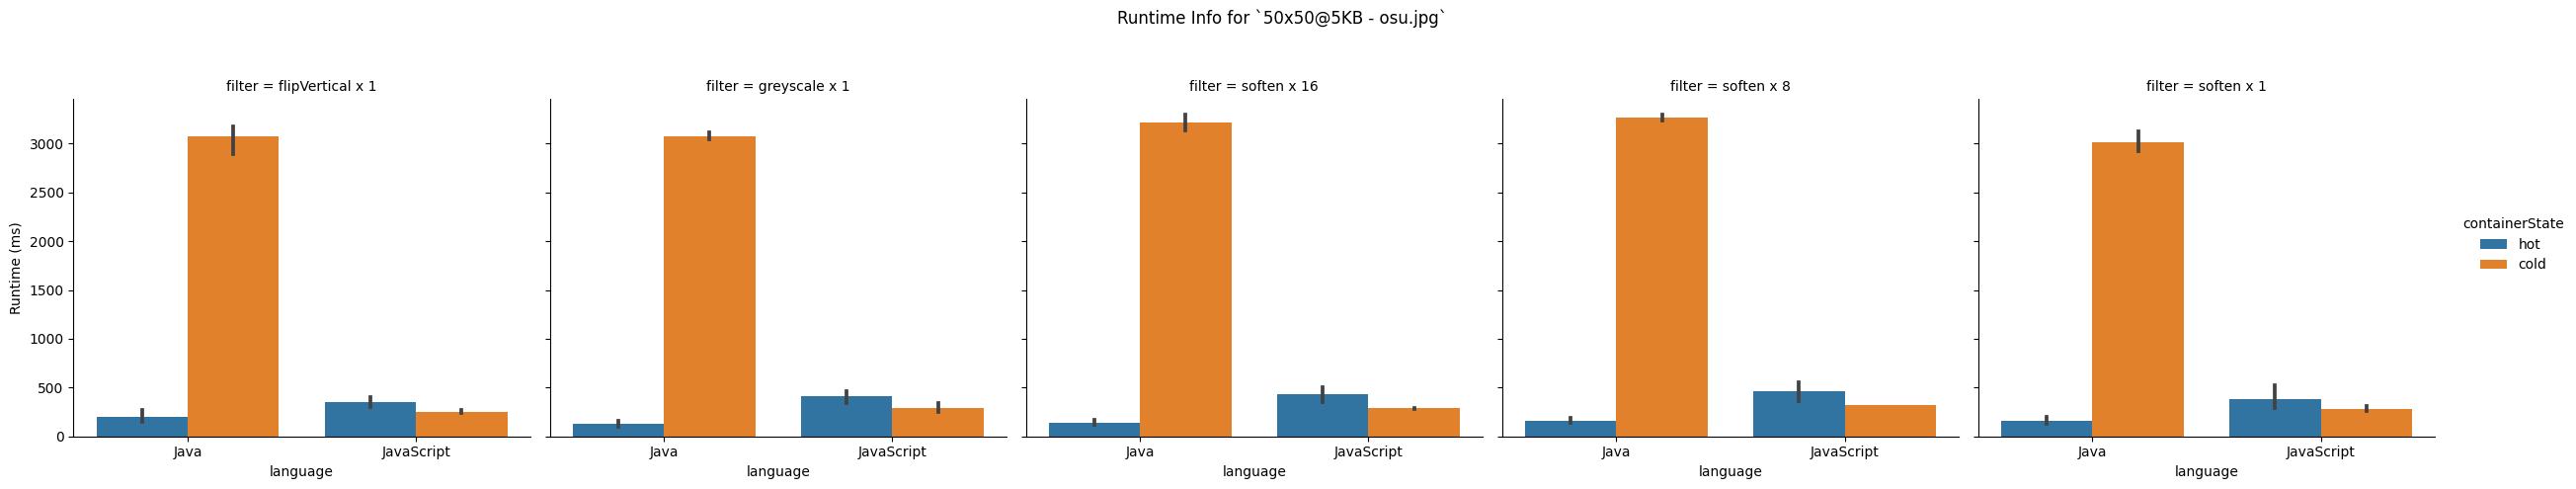

In [85]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename)
]

results = sns.catplot(
    data,
    kind="bar",
    x="language", y="runtime",
    hue="containerState",
    col="filter", palette=["#ff7f0e", "#1f77b4"],
)
results.set_ylabels("Runtime (ms)")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}`")

display(global_widgets["shortName"])
results

Dropdown(description='shortName', options=('osu', 'husky', 'vietfood', 'deathstar', 'mountains', 'lanterns'), …

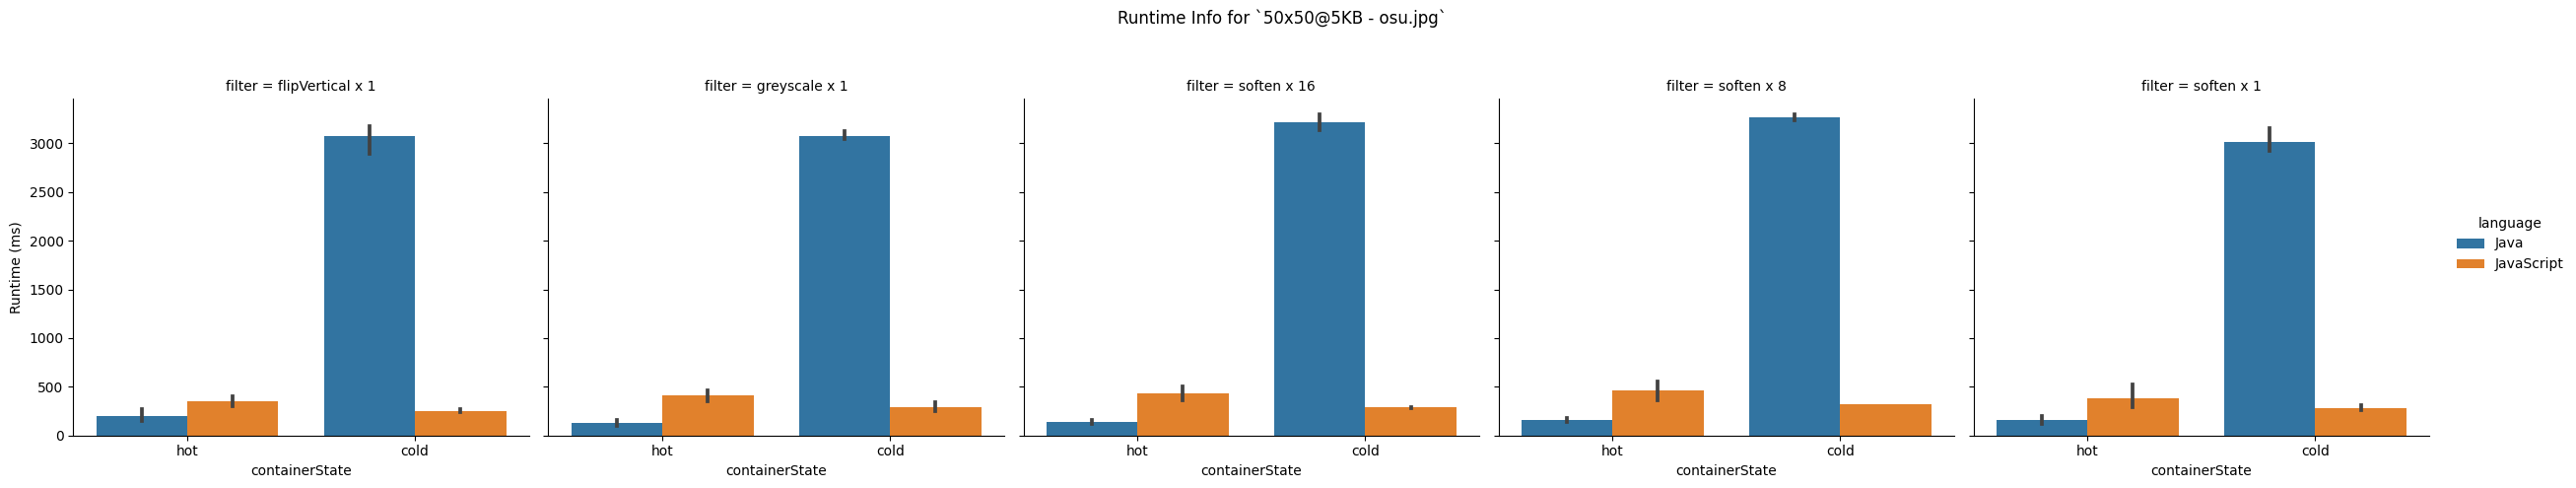

In [82]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename)
]

results = sns.catplot(
    data,
    kind="bar",
    x="containerState", y="runtime",
    hue="language",
    col="filter",
)
results.set_ylabels("Runtime (ms)")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}`")

display(global_widgets["shortName"])
results

In [21]:
grouped_columns = [
    # "cpuType",
    "fileID", "filter", "containerState", "language",
]
runtime_results = df.groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

runtime_results

average runtime (ms)  \
fileID                 filter           container_state language                           
deathstar (1920, 1200) flipVertical x 1 cold            Java                 4036.000000   
                                                        JavaScript           1312.333333   
                                        hot             Java                  813.769231   
                                                        JavaScript           1319.000000   
                       greyscale x 1    cold            Java                 3853.666667   
...                                                                                  ...   
vietfood (700, 466)    soften x 16      hot             JavaScript           1554.833333   
                       soften x 8       cold            Java                 4418.000000   
                                                        JavaScript            899.000000   
                                        hot             Java                 1705.000000   
                                                        JavaScript           1008.750000   

                                                                    standard deviation  \
fileID                 filter           container_state language                         
deathstar (1920, 1200) flipVertical x 1 cold            Java                       NaN   
                                                        JavaScript           52.290853   
                                        hot             Java                347.705612   
                                                        JavaScript           96.249675   
                       greyscale x 1    cold            Java                 83.936484   
...                                                                                ...   
vietfood (700, 466)    soften x 16      hot             JavaScript          126.517061   
                       soften x 8       cold            Java                121.622366   
                                                        JavaScript          122.098321   
                                        hot             Java                300.152461   
                                                        JavaScript           54.603877   

                                                                    sample size  
fileID                 filter           container_state language                 
deathstar (1920, 1200) flipVertical x 1 cold            Java                  1  
                                                        JavaScript            3  
                                        hot             Java                 13  
                                                        JavaScript           11  
                       greyscale x 1    cold            Java                  3  
...                                                                         ...  
vietfood (700, 466)    soften x 16      hot             JavaScript            6  
                       soften x 8       cold            Java                  2  
                                                        JavaScript            3  
                                        hot             Java                  5  
                                                        JavaScript            4  

[119 rows x 3 columns]

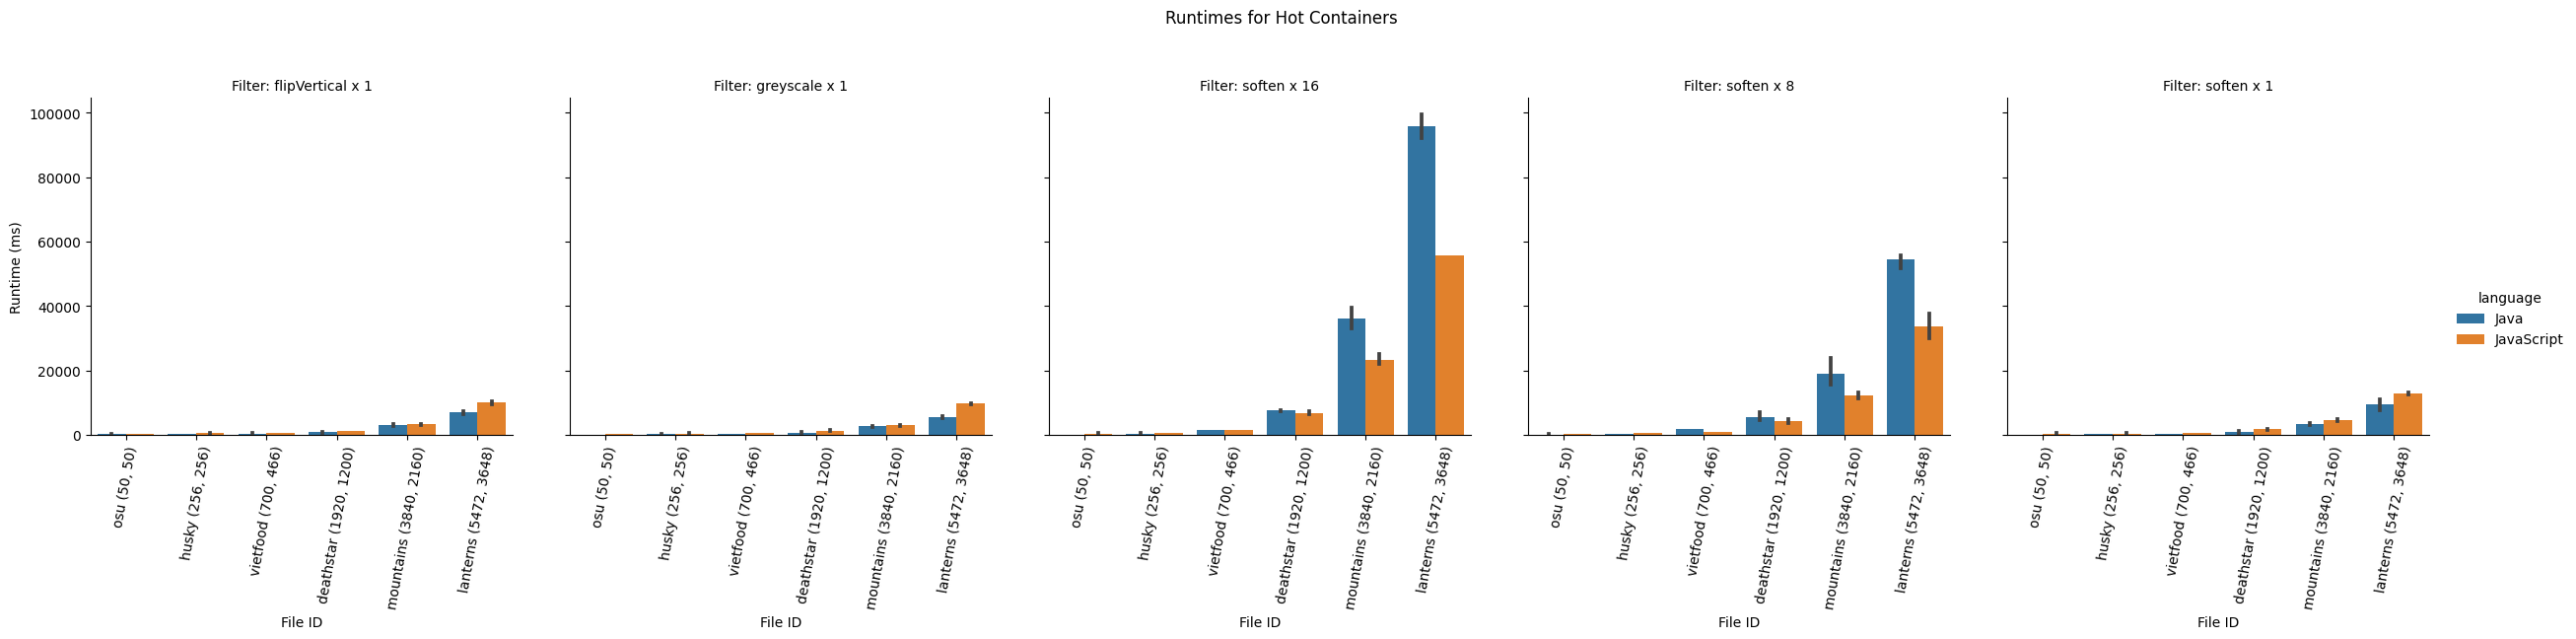

In [12]:
hot_results = sns.catplot(
    df[df["containerState"] == "hot"], x="fileID", y="runtime", hue="language",
    col="filter", kind="bar",
)
hot_results.set_axis_labels("File ID", "Runtime (ms)")
hot_results.set_titles("Filter: {col_name}")
hot_results.figure.subplots_adjust(top=0.8)
hot_results.figure.suptitle("Runtimes for Hot Containers")
hot_results.set_xticklabels(rotation=80)

hot_results

In [ ]:
cold_results = sns.catplot(
    df[df["containerState"] == "cold"], x="pixelAmount", y="runtime", hue="language",
    col="filter", kind="bar",
)
cold_results.set_axis_labels("Filename", "Runtime (ms)")
cold_results.set_titles("Filter: {col_name}")
cold_results.figure.subplots_adjust(top=0.8)
cold_results.figure.suptitle("Runtimes for Cold Containers")
cold_results.set_xticklabels(rotation=80)

cold_results

In [ ]:
hot_cold_results = sns.catplot(
    df, x="shortName", y="runtime", hue="language",
    col="filter", row="containerState", kind="bar",
)
hot_cold_results.set_axis_labels("Pixel Amount", "Runtime (ms)")
hot_cold_results.set_titles("Filter: {col_name}\nContainer State: {row_name}")
hot_cold_results.figure.subplots_adjust(top=0.9)
hot_cold_results.figure.suptitle("Runtimes for Hot/Cold Containers")

In [ ]:
hot_cold_javascript = sns.catplot(
    df[
        (df["language"] == "JavaScript")
        & (df["filter"] == "soften")
    ],
    x="shortName", y="runtime",
    hue="containerState",
    kind="bar",
)
hot_cold_javascript.set(title="JavaScript Runtimes for Hot/Cold Containers")
hot_cold_javascript.set_xlabels("Filename")
hot_cold_javascript.set_ylabels("Runtime (ms)")
hot_cold_javascript.set_xticklabels(rotation=30)

hot_cold_javascript